# Quantum Euclidean Distance for Two Images using Quantum Fourier Transform

In [1]:
#Notebook written by Miguel de Jesús Martínez Felipe and Divyanshu Singh 
# Quantum Euclidean Distance for Two Images using Quantum Fourier Transform
#https://github.com/Miguelillnino and https://github.com/divshacker

from qiskit import *
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy import pi
from qiskit.circuit.library import QFT
from qiskit.quantum_info import Statevector, state_fidelity, process_fidelity, DensityMatrix
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, pauli_error
from qiskit.providers.aer import AerSimulator
from typing import List, Union
from qiskit.circuit import Gate
import math

#Libraries for Image Processing 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import qiskit
qiskit.__version__

'0.18.1'

In [3]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

/home/miguel/anaconda3/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


In [4]:
IBMQ.save_account('0c36130e3a676af024477eca7ea46d063669eb787b4456993a3b1e22c830d1294d0cc8de85a5f8b5778a6f43c3ec484cac81ec12bddc158b79e95002009efa3e') 

configrc.store_credentials:WARNING:2023-09-18 12:09:37,499: Credentials already present. Set overwrite=True to overwrite.


In [5]:
#!pip install qiskit-ibmq-provider


In this notebook, we will calculate the Euclidean distance with the Quantum Fourier Transform rotation, which can be applied to image processing; we can see an implementation for one pixel and both images.

The topic of similarity/dissimilarity measure can help to solve problems in block matching, and similarity measure. Finding a group of similar image patches inside a search area is essential. In different practical applications often is necessary to find groups of similar image blocks within an ample search area, The problem of image template location in a considered image is very common in different applications such as video compression, image clustering, vector quantization, nonlocal noise reduction; To match templates, various measures of similarity/dissimilarity can be applied.


Given two sequences of measurements $X = {xi : i = 1, . . . , n}$ and $Y = {yi : i = 1, . . . , n}$, the similarity (dissimilarity) between them is a measure that quantifies the dependency (independency) between the sequences. $X$ and $Y$ can represent measurements from two objects or phenomena. So, we assume they represent images and $x_i$ and $y_i$ are intensities of corresponding pixels in the images. If $X$ and $Y$ represent 2-D images, the sequences can be considered intensities in the images in raster-scan order.

A dissimilarity measure $D$ is considered a metric if it produces a higher value as corresponding values in $X$ and $Y$ become less dependent. A metric dissimilarity $D$ satisfies the following for all sequences $X$ and $Y$ [1]:

1. Nonnegativity: $D(X,Y) ≥ 0$.
2. Reflexivity: $D(X,Y) = 0$ if and only if $X = Y$ .
3. Symmetry: $D(X,Y) = D(Y,X)$.
4. Triangle Inequality: $D(X,Y) + D(Y,Z) ≥ D(X,Z)$.

## Square $L_1$ Norm

L1 norm, Manhattan norm, or sum of absolute intensity differences is one of the
oldest dissimilarity measures used to compare images. Given sequences X = {xi :
i = 1, . . . , n} and Y = {yi : i = 1, . . . , n} representing intensities in two images in
raster-scan order, the L1 norm between the images is defined by [2]:

\begin{equation}
{L_1} = \sum_i^n ({x_i}-{y_i})
\end{equation}


## Square $L_2$ Norm (Euclidean distance)
Square L2 norm, square Euclidean distance, or sum of squared intensity differences of corresponding pixels in sequences $X = {xi : i = 1, . . . , n}$ and $Y = {yi : i = 1, . . . , n}$ is defined by:

\begin{equation}
{L_2^2} = \sum_i^n ({x_i}-{y_i})^2
\end{equation}


For this notebook, $L_2$ Norm is implemented; this is because in [1] performance evaluations are determined and the results are compared, taking into account the following points:

1. Sensitivity to Noise
2. Sensitivity to Image Blurring
3. Sensitivity to Imaging View
4. Speed

Each similarity/dissimilarity measure has its strengths and weaknesses. $L_1$ norm, square $L_2$ norm perform better than other measures; square $L_2$ norm ties for the most number of correct matches in sensitivity to noise $L_1$ norm and square $L_2$ norm produce 100\% correct matches; square $L_2$ and $L_1$ norm are fastest methods.

## Quantum Fourier Transform

As explained in [3], the Fourier transform occurs in many different versions throughout classical computing, in areas ranging from signal processing to data compression to complexity theory. The quantum Fourier transform (QFT) is the quantum implementation of the discrete Fourier transform over the amplitudes of a wavefunction. It is part of many quantum algorithms, most notably Shor's factoring algorithm and quantum phase estimation [4].

The Quantum Fourier Transform (QFT) on qubits is the operation:
\begin{equation}
|j\rangle \mapsto \frac{1}{2^{n/2}} \sum_{k=0}^{2^n - 1} e^{2\pi ijk / 2^n} |k\rangle
\end{equation}

For 4 qubits, the circuit that implements this transformation is:

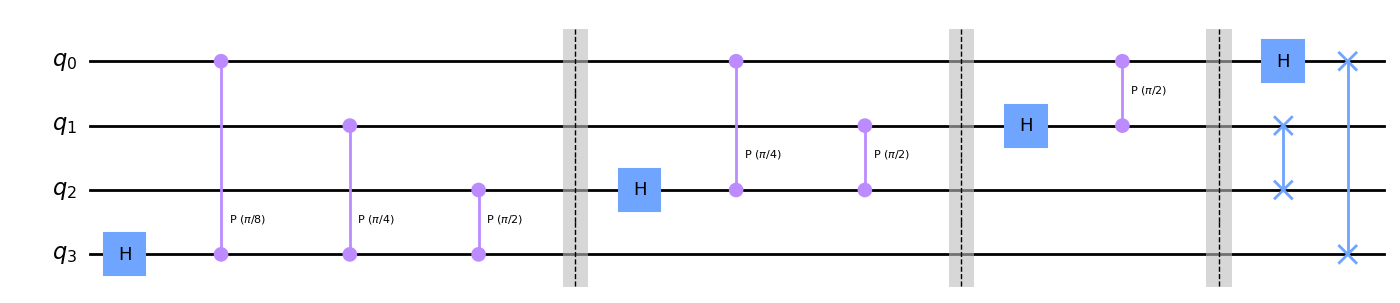

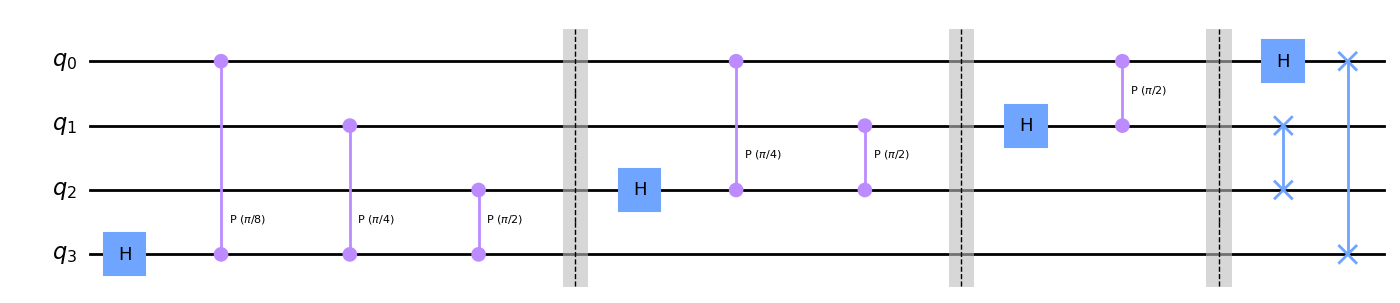

In [6]:
def QFT4qubits(qc):
    qc.h(3)
    qc.cp(pi/8, 0, 3)
    qc.cp(pi/4, 1, 3)
    qc.cp(pi/2, 2, 3)
    qc.barrier()
    qc.h(2)
    qc.cp(pi/4, 0, 2)
    qc.cp(pi/2, 1, 2)
    qc.barrier()
    qc.h(1)
    qc.cp(pi/2, 0, 1)
    qc.barrier()
    qc.h(0)
    qc.swap(0,3)
    qc.swap(1,2)
    
    return qc

qc = QuantumCircuit(4)
QFT4qubits(qc).draw('mpl')

We can see the result in the Fourier state $|˜0⟩$:

In [7]:
#sim = Aer.get_backend("aer_simulator")
#qc_init = qc.copy()
#qc_init.save_statevector()
#statevector = sim.run(qc_init).result().get_statevector()
#plot_bloch_multivector(qc)

Adding X-Pauli gates in $q_0$ and $q_3$ for see results in number 9:

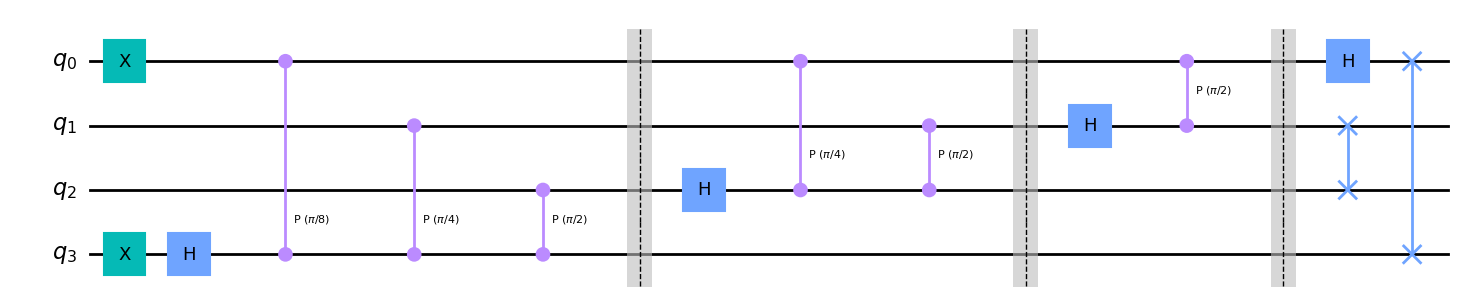

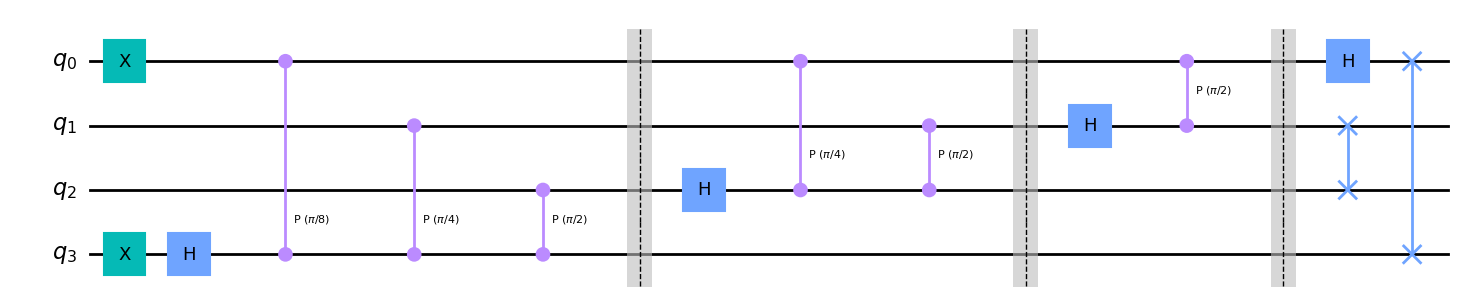

In [8]:
qc = QuantumCircuit(4)
qc.x(0)
qc.x(3)
QFT4qubits(qc).draw('mpl')

We can see the result in the Fourier state $|˜9⟩$:

In [9]:
#sim = Aer.get_backend("aer_simulator")
#qc_init = qc.copy()
#qc_init.save_statevector()
#statevector = sim.run(qc_init).result().get_statevector()
#plot_bloch_multivector(qc)

## Draper Adder

The Draper adder is arguably one of the most elegant quantum adders, as it directly invokes quantum properties to perform addition. The insight behind the Draper adder is that the Fourier transform can be used to translate phase shifts into a bit shift. It then follows that by applying a Fourier transform, applying appropriate phase shifts, and then undoing the Fourier transform you can implement an adder. Unlike many other adders that have been proposed, the Draper adder explicitly uses quantum effects introduced through the quantum Fourier transform. It does not have a natural classical counterpart. The specific steps of the Draper adder are given below [5-6].

The path towards performing an adder then becomes clear after observing that the sum of the inputs can be written as:

\begin{equation}
|a+b⟩ = QFT^-1 |\phi_1(a+b)⟩ \otimes \cdots \otimes |\phi_n(a+b)⟩
\end{equation}


The integers b and a can then be added by performing controlled-phase rotation on each of the qubits in the decomposition using the bits of b as controls.

This expansion can be further simplified by noting that for any integer $j$ and real number $x$, $e^{i2π(x+j)}=e^{i2πx}$. This is because if you rotate 360∘ degrees (2π radians) in a circle then you end up precisely where you started. The only important part of x for e^{i2πx] is therefore the fractional part of $x$. Specifically, if we have a binary expansion of the form $x=y+0.x_0x_2\cdots x_n$ then $e^{i2πx}=e^{i2π(0.x_0x_2\cdots x_n−1)}$ and hence:

\begin{equation}
|\phi_k(a+b)⟩ = \frac{1}{\sqrt{2}} |0⟩ + e^{i2π[a/2^{k} +0.b_{k}\cdots b_1]}  |1⟩
\end{equation}


This means that if we perform addition by incrementing each of the tensor factors in the expansion of the Fourier transform of |a⟩ then the number of rotations shrinks as k decreases. This substantially reduces the number of quantum gates needed in the adder. We denote the Fourier transform, phase addition and the inverse Fourier transform steps that comprise the Draper adder as QFT−1(ϕADD)QFT [7], a quantum circuit that uses this simplification to implement the entire process can be seen below.

<img style="float: centering;" src="https://docs.microsoft.com/en-us/azure/quantum/media/draper.svg">

Each controlled $e^{i2\frac{π}{k}}$ gate in the circuit refers to a controlled-phase gate. Such gates have the property that on the pair of qubits on which they act, |00⟩↦|00⟩ but |11⟩↦$e^{i2\frac{π}{k}}$|11⟩. This circuit allows us to perform addition using no additional qubits apart from those needed to store the inputs and the outputs.

## Novel Enhanced Representation for Quantum Images

The Novel Enhanced Quantum Representation (NEQR) is one of the earlier forms of quantum image representation. In that it uses a normalized superposition to store pixels in an image. NEQR was created to leverage the basis state of a qubit sequence to store the image's grayscale value [8].

In order to represent an image on a quantum computer using the NEQR model, we'll first look at the various components required to do so and how they are related to each other. We'll begin with the color range of the image.

The color range of an image is represented by a bitstring as follows: Binary Image: 1 bit representing 0=black, and 1=white

Grayscale Image: 8 bits representing the various shades of gray intensity values between 0 (black) and 255 (white).

Color Image: 24 bits, are broken up into 3 groups of 8 bits, where each group of 8 bits represents the Red, Green, and Blue intensities of the pixel color.

### Encoding 4-bit pixel values in 4 qubits example:

In the table below we have the first column which represents the grayscale pixel coordinate of the image ($f(X,Y)$). The second column represents the intensity value at the specified pixel position for this notebook it is a 4-bit pixel value. The third column is a description of the grayscale intensity (ex: 0111 = 7).

\begin{array}{|c|c|c|}
\hline
position & binary \; string & grayscale \; intensity \\
\hline
f(0,1) & |0000⟩ & 0 - Black  \\
\hline
f(0,1) & |0100⟩ & 4 - Dark shade \\
\hline
f(1,0) & |1100⟩ & 12 - Light shade  \\
\hline
f(1,1) & |1111⟩ & 15 - White \\
\hline
\end{array}

To encode these pixels, we will need to define our quantum registers, the first register we will use to store the pixel position. Since this is a 2D image we will need two variables related to the horizontal (column) and the other the vertical (row), X and Y, respectively.

The colour value of each pixel is denoted as f(X,Y), where X and Y specify the pixel position in the image by column and row, respectively.

The range of the grayscale intensity for each pixel can vary however, for this notebook the grayscale range is from 0 - 15, the values is usually denoted as $2^{q}$, where for 16, we can confirm q=4. Where q represents the number of bits needed for the binary sequence of colors: C0,C1,Cq−2,Cq−1.

This means that each pixel value can be represented as follows, where C is a binary representation of the grayscale intensity value:

\begin{equation}
f(Y,X) = C^{0}_{XY}, C^{1}_{XY}, C^{q-2}_{XY}, C^{q-1}_{XY} \in [0,1], \;\; f(X,Y)\in[0, 2^{q-1}]
\end{equation}

For example for a pixel at position $f(1,0)$ with a colour intensity of 12 (1100), it would be represented as follows:

\begin{equation}
f(1,0) = C^{0}_{10}, C^{1}_{10}, \overline{C^{2}_{10}}, \overline{C^{3}_{10}} = 1100 = 12
\end{equation}

## Implementation:
For this first example, we need to code the right and left rotations; as we can see, we can perform rotations to the right with the QFT, so when we want to rotate some binary value to the left, so we need to reverse the sign (-) to the rotations.
Also to encode each pixel from the images we need implement the Draper adder, remember that using controlled-phase gate "Each controlled $𝑒^{𝑖2\frac{π}{𝑘}}$ gate in the circuit refers to a controlled-phase gate" (the CU1 Gate is equivalent to CPhaseGate, so we can implement both solving the same rotation), so we have:

\begin{split}CPhase =
    |0\rangle\langle 0| \otimes I + |1\rangle\langle 1| \otimes P =
    \begin{pmatrix}
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & 1 & 0 \\
        0 & 0 & 0 & e^{i\lambda}
    \end{pmatrix}\end{split}
    
 So for the most significant value ($q_0$) we rotate $cp(1*pi/(8), q_0, q_8)$ (8 times)
 
 for the second value ($q_1$) we rotate $cp(1*pi/(4), q_1, q_9)$ (4 times)
 
 for the third value ($q_2$) we rotate $cp(1*pi/(2), q_2, q_10)$ (2 times)
 
 and for the less significant value ($q_3$) we rotate $cp(1*pi, q_3, q_11)$ (1 time)
 
 
 The same encode for each pixel from the second images insted of rotate to the right, this pixel value rotate to the left with the sign = -1:
 
  So for the most significant value ($q_4$) we rotate $cp(-1*pi/(8), q_4, q_8)$ (8 times)
 
 for the second value ($q_5$) we rotate $cp(-1*pi/(4), q_5, q_9)$ (4 times)
 
 for the third value ($q_6$) we rotate $cp(-1*pi/(2), q_6, q_10)$ (2 times)
 
 and for the less significant value ($q_7$) we rotate $cp(-1*pi, q_7, q_11)$ (1 time)
 
It is essential to use four qubits ($q_0,q_1,q_2,q_3$) for the first image pixel, and four qubits ($q_4,q_5,q_6,q_7$) for the second image pixel (remember that $q_0$ and $q_4$ is the most significant value in binary representation), so in this case 4-bit pixel in grey scale are needed for the range of (0,1,$\cdots$,14,15) using the NEQR encode, and for the ($q_8,q_9,q_{10},q_{11}$) we implement the Draper Adder [7], we implement the QFT, note that the library qiskit.circuit.library provides the QFT, and we just need to append the circuit.


In [10]:
def add_qubit(qc, q, sign = 1):
    if q > 3:
        sign = -sign
        
    for indx, qb in enumerate(range(8,12)):
        qc.cp(sign * pi / (2**(3 - indx)), q, qb)
    

In [11]:
# For 2 qubits per image
# firstPart = 3
# secondPart = 1
# secondPart = secondPart -2
# firstPart = firstPart - 2

# For 4 qubits per image
# firstPart = 5
# secondPart = 1

def rotationsFourier(qc, sign = 1):
    qc.append(QFT(4), range(8,12))
    qPrima = 0
#   firstPart y secondPart, number of rotations
    firstPart = 5
    secondPart = 1
    for q in range(0,8):
        if q > 3:
            secondPart = secondPart -2
            qPrima = q + secondPart
        else:
            firstPart = firstPart - 2
            qPrima = q + firstPart
#         print(q)
        for index in range(0,2**qPrima):
            add_qubit(qc, q, sign)
            qc.barrier()
   
    qc.append(QFT(4,inverse=True), range(8,12)) #invQFT(4)

In this case, we make an example for one pixel, in the first value $q_0,q_1,q_2,q_3$, 15 is the number represented for the 4-bit  grey scale pixel value. And for $q_4,q_5,q_6,q_7$, 8 is the number represented. You can see the circuit for this example.

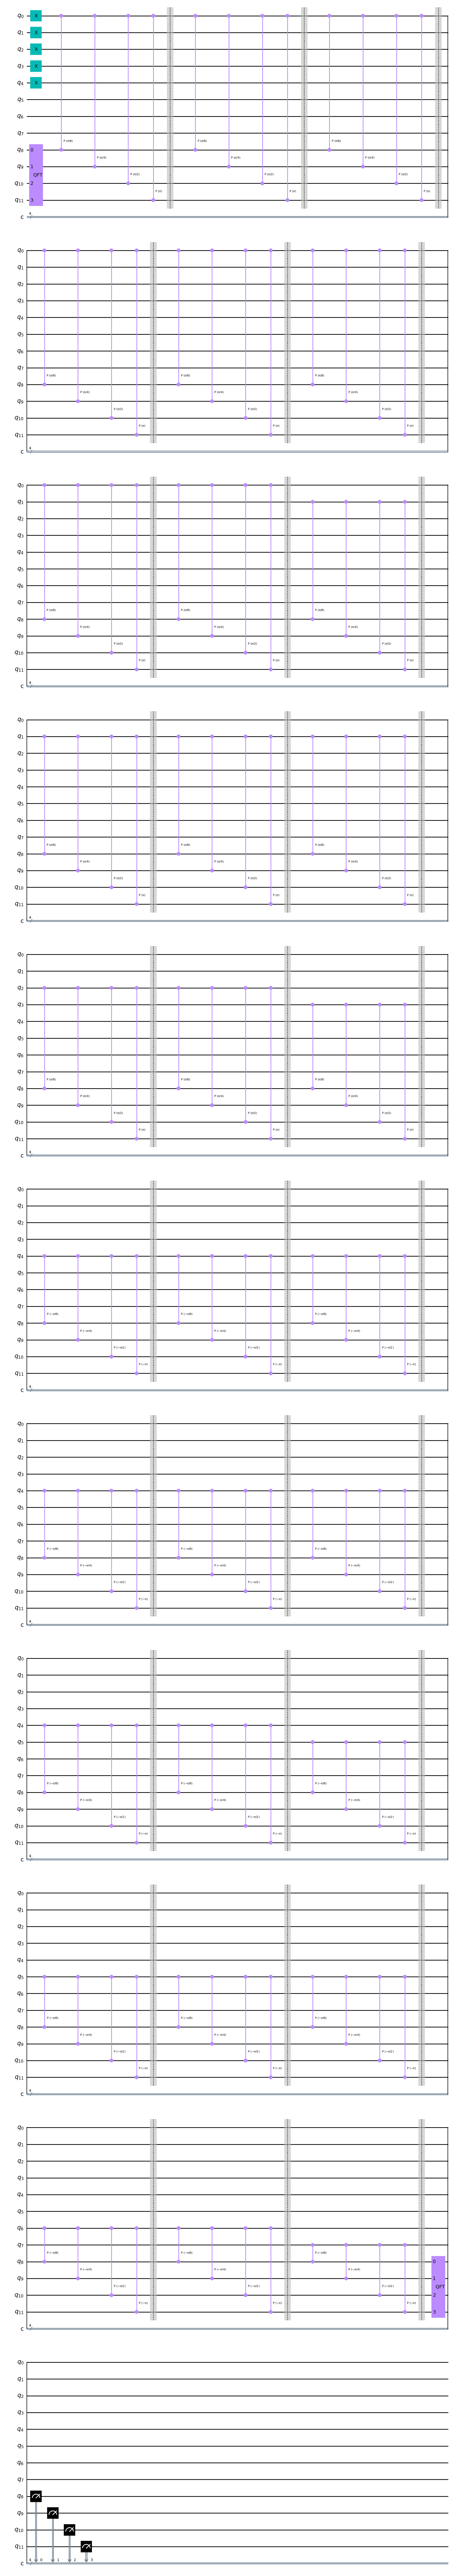

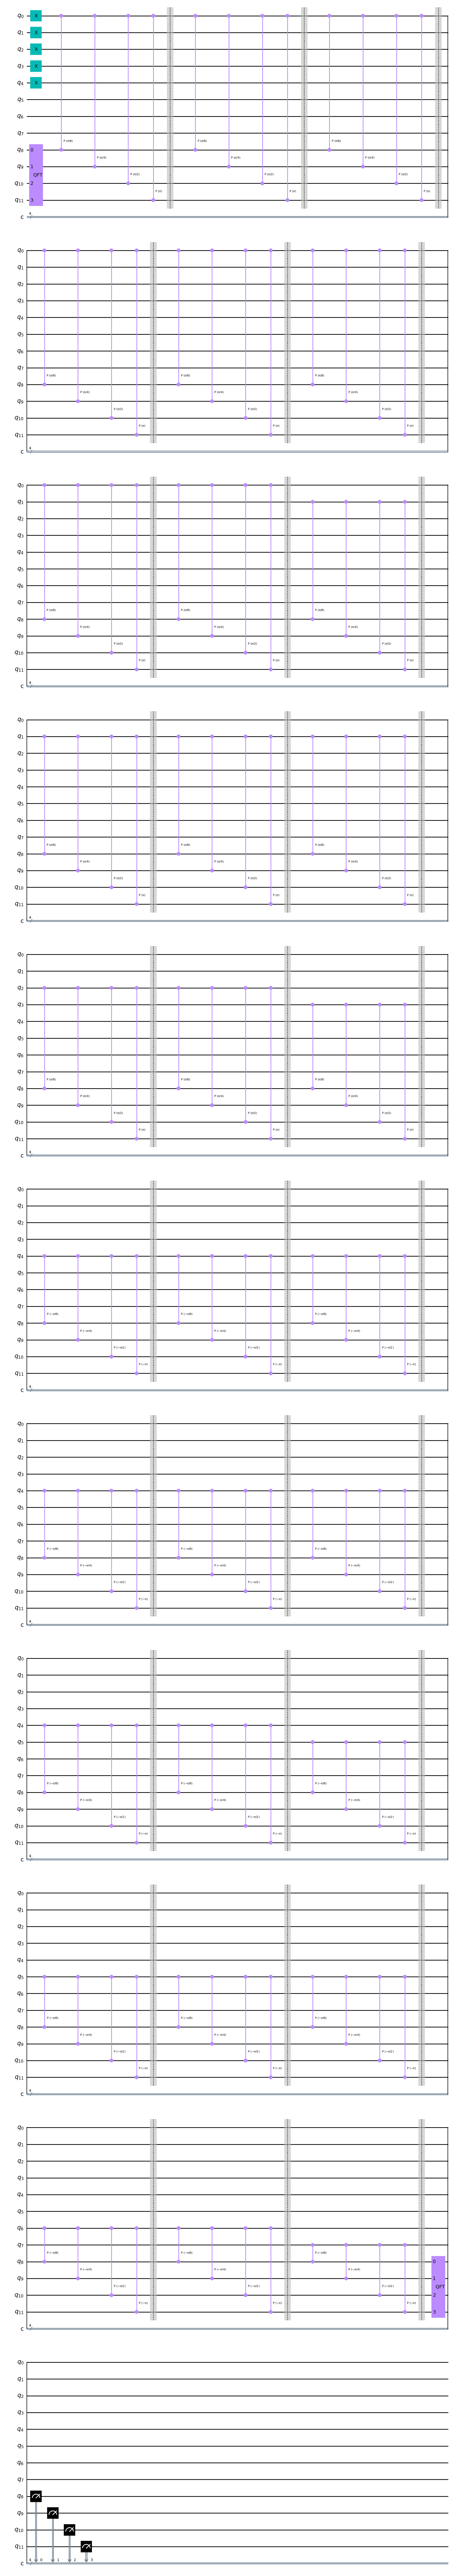

In [12]:
qc = QuantumCircuit(12,4)
# Pixel from the first image
qc.x(0)
qc.x(1)
qc.x(2)
qc.x(3)
# ------------------------------
# ------------------------------
# ------------------------------
# Pixel from the second image
qc.x(4)

rotationsFourier(qc)

qc.measure(range(8,12), range(4))
#qc = qc.reverse_bits()

qc.draw('mpl')


Since we execute the quantum circuit we can see the result in binary value, so '0111' it is the number 7 if we do a conversion to decimal. So we make 15 rotations to the right and eight rotations to the letf, so in this case $15-8=7$

/home/miguel/anaconda3/lib/python3.8/site-packages/qiskit/visualization/counts_visualization.py:226: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


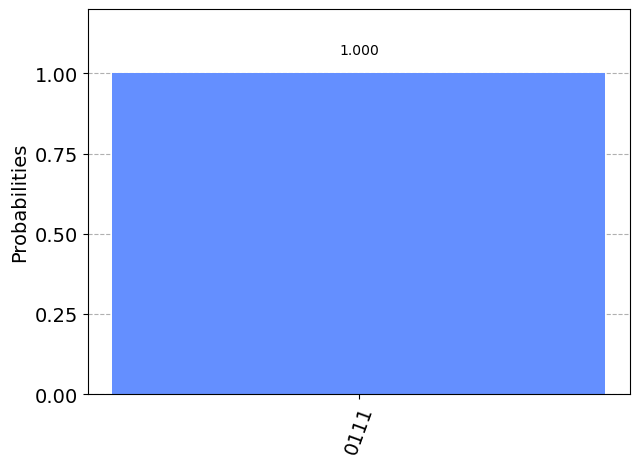

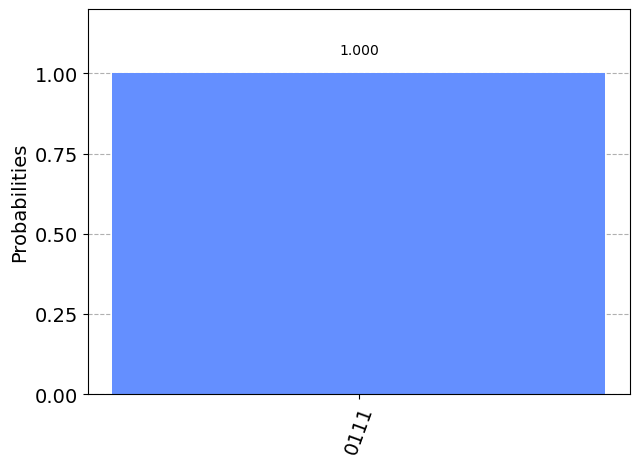

In [13]:

backend = Aer.get_backend('qasm_simulator')
job_sim = backend.run(transpile(qc,backend), shots=1024)

#job = execute(qc, backend, shots = 5)
plot_histogram(job_sim.result().get_counts())


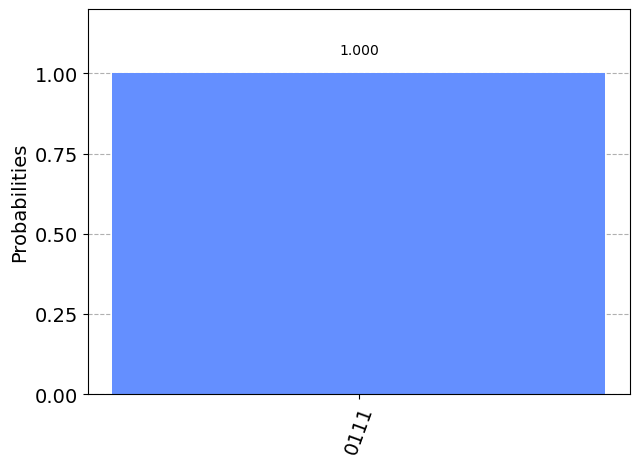

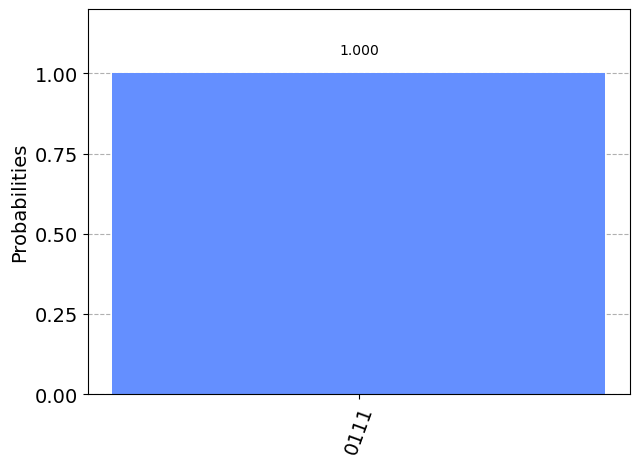

In [14]:
simulator = Aer.get_backend('qasm_simulator')
job_other = execute(qc, simulator, shots=8192, optimization_level=3)
result_other = job_other.result()
counts_other = result_other.get_counts(qc)
plot_histogram(counts_other)

In [15]:
print(job_other.version)

1


In [16]:
qc.count_ops()

OrderedDict([('cp', 120),
             ('barrier', 30),
             ('x', 5),
             ('measure', 4),
             ('QFT', 2)])

In [17]:
qc.depth()

123

In [18]:
#qc.count_ops()
qc.decompose().decompose().count_ops()

OrderedDict([('u', 365),
             ('cx', 240),
             ('barrier', 30),
             ('cp', 12),
             ('h', 8),
             ('swap', 4),
             ('measure', 4)])

In [19]:
qc.decompose().decompose().depth()

526

In [20]:
print(job_sim)

Now, we can perform our circuit with an actual image; Fistable, it is crucial to have two images, one original image in a grey scale and the same image with some Gaussian nosie, since we want to measure the Euclidean distance between them.

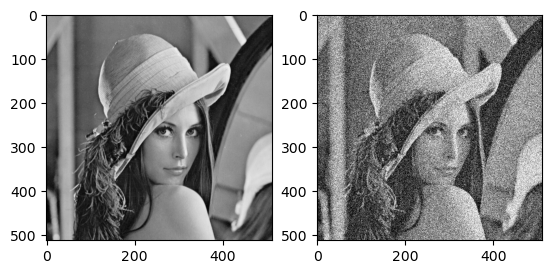

In [13]:
originalImage = cv2.imread('lena_gray.png')
grayOriginalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
noisyImage = cv2.imread('lena_gray_512_512_variance_400.png')
grayNoisyImage = cv2.cvtColor(noisyImage, cv2.COLOR_BGR2GRAY)
plt.subplot(1,2,1)
plt.imshow(grayOriginalImage, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(grayNoisyImage, cmap='gray')
plt.show()

The second important step it is resized both image from $512\times512$ to $64\times64$ pixels (we can perform the quantum circuit with the original size but it will take too much time)


Original Image Dimensions :  (512, 512)
Resized Original Image Dimensions :  (64, 64)
Resized Noisy Image Dimensions :  (64, 64)


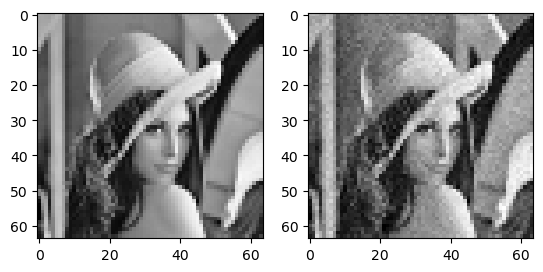

In [14]:
print('Original Image Dimensions : ',grayOriginalImage.shape) # Since images are 512x512 size
scale_percent = 12.5 # percent of original size for a 64x64 size
width = int(grayOriginalImage.shape[1] * scale_percent / 100)
height = int(grayOriginalImage.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize Original image
resizedOriginalImage = cv2.resize(grayOriginalImage, dim, interpolation = cv2.INTER_AREA)
print('Resized Original Image Dimensions : ',resizedOriginalImage.shape)
# resize Noisy image

resizedNoisyImage = cv2.resize(grayNoisyImage, dim, interpolation = cv2.INTER_AREA)
print('Resized Noisy Image Dimensions : ',resizedNoisyImage.shape)


plt.subplot(1,2,1)
plt.imshow(resizedOriginalImage, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(resizedNoisyImage, cmap='gray')
plt.show()

In [15]:
cv2.imwrite('resizedOriginalImage.png',resizedOriginalImage)
cv2.imwrite('resizedNoisyImage.png',resizedNoisyImage)

True

In [16]:
print(resizedOriginalImage)

[[160 159 156 ... 125 120 136]
 [156 157 156 ... 129  97  50]
 [156 157 157 ...  93  49  49]
 ...
 [ 68 106 169 ... 101  68  61]
 [ 56  82 180 ...  83  59  56]
 [ 50  69 192 ...  55  58  87]]


The next step is to reduce the 8-bit pixel to 4-bit pixel, since we have an image of 8-bit pixel, making 256 rotations it not will be an option for a quantum circuit (this for the time consuming), for the 4-bit pixel, we can divide each value of the pixel by 17 from the 64x64 image.

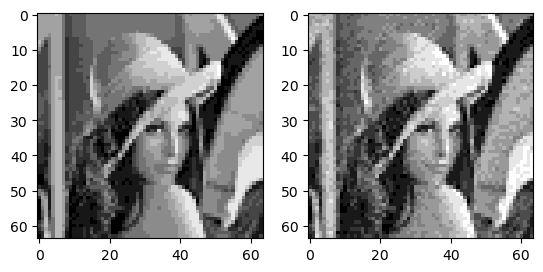

<Figure size 640x480 with 0 Axes>

In [17]:
[hight,lenght] = resizedOriginalImage.shape

#Build an array for the original image 64*64
arrayOriginalImage = np.arange(0, 4096, 1, np.uint8)
arrayOriginalImage = np.reshape(arrayOriginalImage, (64, 64))

#CBuild an array for the noisy image de 64*64
arrayNoisyImage = np.arange(0, 4096, 1, np.uint8)
arrayNoisyImage = np.reshape(arrayNoisyImage, (64, 64))

for altura in range(0,hight):
    for ancho in range (0,lenght):
        arrayOriginalImage[altura,ancho] = int(resizedOriginalImage[altura,ancho]/17)
        arrayNoisyImage[altura,ancho] = int(resizedNoisyImage[altura,ancho]/17)        
        
plt.subplot(1,2,1)
plt.imshow(arrayOriginalImage, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(arrayNoisyImage, cmap='gray')
plt.show()
plt.savefig('filename.png')

In [18]:
print(arrayOriginalImage)

[[ 9  9  9 ...  7  7  8]
 [ 9  9  9 ...  7  5  2]
 [ 9  9  9 ...  5  2  2]
 ...
 [ 4  6  9 ...  5  4  3]
 [ 3  4 10 ...  4  3  3]
 [ 2  4 11 ...  3  3  5]]


In [19]:
print(arrayNoisyImage)

[[ 9  9  9 ...  7  7  7]
 [ 8  8  9 ...  7  6  3]
 [ 8  9  8 ...  4  3  2]
 ...
 [ 4  6 10 ...  5  3  4]
 [ 4  4 10 ...  4  3  4]
 [ 3  4 11 ...  3  3  5]]


In [20]:
print(arrayOriginalImage-arrayNoisyImage)

[[  0   0   0 ...   0   0   1]
 [  1   1   0 ...   0 255 255]
 [  1   0   1 ...   1 255   0]
 ...
 [  0   0 255 ...   0   1 255]
 [255   0   0 ...   0   0 255]
 [255   0   0 ...   0   0   0]]


In [26]:
cv2.imwrite('FourOriginalImage.png',arrayOriginalImage)
cv2.imwrite('FourNoisyImage.png',arrayNoisyImage)

True

In [27]:
plt.imsave('FourOriginalImage.png', arrayOriginalImage,cmap='gray')
plt.imsave('FourNoisyImage.png', arrayNoisyImage,cmap='gray')

After having our images in the desired format, the next step it is to measures the result of each pixel performed in the quantum circuit. Since we have, nevertheless, it is essential to complete all the binaries values, because if we have a number '0011' when we convert the number, the result will be '11', so it is necessary to complete the string form of the binary value for the four qubits

In [28]:
def completeStringValue(longValue,strignValue):
    resta = longValue - len(strignValue)
    Ceros = ''
    if resta !=0:
        for i in range(0,resta):
            Ceros += '0'      
    return Ceros+strignValue

There is one condition to take into account, when we have a pixel value in our first image that is greater than the second pixel value example: $0101 - 0110$ the result will be $1111$ but in decimal numbers $5 - 6 = -1$. And '1111' (binary) $\neq$ 1 (decimal) , so we consider the negative binary number as a complement, in this case for 4-bit pixel:

-1111 = -1

-1110 = -2

$\vdots$

-0010 = -14

-0001 = -15

In [29]:
# listaCircuits = []
# for i in range (0,arrayOriginalImage.shape[0]):
#     for j in range (0,arrayOriginalImage.shape[1]):
#         binaryPixelOne = bin(int(arrayOriginalImage[i,j]))
#         binaryPixelTwo = bin(int(arrayNoisyImage[i,j]))
#         CompleteBinaryOne = completeStringValue(4,binaryPixelOne[2:len(binaryPixelOne)])
#         CompleteBinaryTwo = completeStringValue(4,binaryPixelTwo[2:len(binaryPixelTwo)])
#         valueBinaryOne = str(CompleteBinaryOne)
#         valueBinaryOTwo = str(CompleteBinaryTwo)

# # Pixeles from Fisrt Image
# # ------------------------------
# # ------------------------------
# # ------------------------------
# # ------------------------------
#         qc = QuantumCircuit(13,5)
#         for idx, px_value in enumerate(valueBinaryOne[::1]):
#             if(px_value=='1'):
#                 qc.x(idx)
                
# # Pixels from Second Image
# # ------------------------------
# # ------------------------------
# # ------------------------------
# # ------------------------------

#         for idy, py_value in enumerate(valueBinaryOTwo[::1]):
#             if(py_value=='1'):
#                 qc.x(idy+4)
#         rotationsFourier(qc)
# ####
# #### Condition for negative numbers
# ####
#         if (int(arrayOriginalImage[i,j]) < int(arrayNoisyImage[i,j])) and (int(arrayOriginalImage[i,j]) - int(arrayNoisyImage[i,j]) != 0) :
#             qc.x(12)
#         qc.measure(range(8,13), range(5))
#         listaCircuits.append(qc)
# #qc.draw()

In [30]:
#backend = Aer.get_backend('qasm_simulator')
#job = execute(listaCircuits, backend, shots = 5)
## plot_histogram(job.result().get_counts())

The last step after appending  all the values in a list of circuits and execute the circuits in order to get the counts we need to compare our result with the classical part. In this case after converting the binary number, remember that for the negative binary numbers we need to make a complement, in this case we did a condition if there is a negative binary number we use a qubit to make a flag for identifying all the negative binary numbers, in this case we execute the X-Pauli gate in the circuit. So when we get that number we only rest the complement from 16 to get the right value.

In [31]:
# distance = 0
# result_submissions = job.result()
# for qc in listaCircuits:
#     counts = result_submissions.get_counts(qc)
#     number= list(counts)[0]
#     if number[0] == '0':
#         dec_number= int(number, 2)
#     else:
#         dec_number= int(number[1:len(number)], 2) - 16

#     distance += (dec_number**2)
# print(distance)

In this work we have seen how to calculate the Euclidean distance (${L_2^2} = \sum_i^n ({x_i}-{y_i})^2$) between two images in a quantum circuit using the Draper adder, QFT and encoding 4-bit pixel images with the NEQR. The advantage of using the quantum approach is that we need 4 qubits to represent the 16 classical bits since $2^{q}$, for this notebook $2^{4} = 16$ in the images representations.

In [32]:
# dist = 0
# for i in range(0,arrayOriginalImage.shape[0]):
#     for j in range(0,arrayOriginalImage.shape[0]):
#         number = (int(arrayOriginalImage[i,j])-int(arrayNoisyImage[i,j]))
#         dist += number**2

# dist

Also, we can see that in a quantum simulator, the result is the same as the classical part in the Euclidean distance calculation, in this case two For loops are needed to make the rest between each pixel value in an image and after this elevate to square for obtaining the same result.

## References:

[1] Goshtasby, A. Ardeshir. Image registration: Principles, tools and methods. Springer Science & Business Media, 2012.

[2] Theodoridis, Sergios, et al. Introduction to pattern recognition: a matlab approach. Academic Press, 2010.

[3] https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html

[4] M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).

[5] https://qiskit.org/documentation/stubs/qiskit.circuit.library.DraperQFTAdder.html

[6] https://docs.microsoft.com/en-us/azure/quantum/user-guide/libraries/standard/algorithms

[7] T. G. Draper, Addition on a Quantum Computer, 2000. arXiv:quant-ph/0008033

[8] https://qiskit.org/textbook/ch-applications/image-processing-frqi-neqr.html

[]

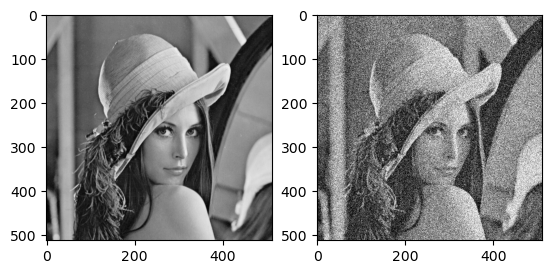

In [33]:
originalImage = cv2.imread('lena_gray.png')
grayOriginalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
noisyImage = cv2.imread('lena_gray_512_512_variance_400.png')
grayNoisyImage = cv2.cvtColor(noisyImage, cv2.COLOR_BGR2GRAY)
plt.subplot(1,2,1)
plt.imshow(grayOriginalImage, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(grayNoisyImage, cmap='gray')
plt.show()

In [34]:
tamParche = 4
imagecopyOriginal = np.copy(arrayOriginalImage[0:tamParche,0:tamParche]) #arrayOriginalImage || grayOriginalImage
imagecopyNoise = np.copy(arrayNoisyImage[0:tamParche,0:tamParche])#arrayNoisyImage || grayNoisyImage
#print(imagecopy)
imagenActualBlur = cv2.GaussianBlur(imagecopyOriginal,(3,3),0)
imagenNoiseBlur = cv2.GaussianBlur(imagecopyNoise,(3,3),0)

print(imagenActualBlur)
print(imagenNoiseBlur)
lenParche=int(tamParche/2)
imageOriginalFilter = np.array([[0,0], [0,0]], np.uint8)
imageNoiseFilter = np.array([[0,0], [0,0]], np.uint8)

for rx_Pache in range(0,tamParche,2):
    for ry_Pache in range(0,tamParche,2):        
        imageOriginalFilter[int(rx_Pache/2),int(ry_Pache/2)] = imagenActualBlur[rx_Pache,ry_Pache]
        imageNoiseFilter[int(rx_Pache/2),int(ry_Pache/2)] = imagenNoiseBlur[rx_Pache,ry_Pache]
print(imageOriginalFilter)
print(imageNoiseFilter)

[[9 9 9 9]
 [9 9 9 9]
 [9 9 9 9]
 [9 9 9 9]]
[[9 9 9 9]
 [8 9 9 9]
 [8 9 9 9]
 [9 9 9 9]]
[[9 9]
 [9 9]]
[[9 9]
 [8 9]]


In [35]:
arrayOriginalFilter = imageOriginalFilter.reshape(-1)#arrayOriginFilter = 
arrayNoiseFilter = imageNoiseFilter.reshape(-1)#.asarray(imageNoiseFilter)

In [36]:
print(arrayOriginalFilter)
print(arrayNoiseFilter)

[9 9 9 9]
[9 9 8 9]


In [37]:
arreglo = [1,8,7,5] 

In [38]:
normalization = 0
normalized_amplitudes = arrayOriginalFilter / np.linalg.norm(arrayOriginalFilter)
print(normalized_amplitudes)
normalized_amplitudes_noisy = arrayNoiseFilter / np.linalg.norm(arrayNoiseFilter)
print(normalized_amplitudes_noisy)
normalized_amplitudes_noisy = [255,255,255,255] / np.linalg.norm([255,255,255,255])
print(normalized_amplitudes_noisy)

#normalization

[0.5 0.5 0.5 0.5]
[0.51365713 0.51365713 0.45658412 0.51365713]
[0.5 0.5 0.5 0.5]


In [39]:
### Phase Operator ###
# return part
def phase_return(index_qubits: int, gamma: float, L1: list, L2: list, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qr_index = QuantumRegister(index_qubits, "index")
    qc = QuantumCircuit(qr_index)
    if gamma == 1:
        return qc.to_gate(label=" phase return ") if to_gate else qc
    for i in range(index_qubits):
        qc.p(-gamma*(L2[i]-L1[i]),i)
    return qc.to_gate(label=" phase return ") if to_gate else qc

In [40]:
def phase_return(index_qubits: int, gamma: float, L1: list, L2: list, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qr_index = QuantumRegister(index_qubits, "index")
    qc = QuantumCircuit(qr_index)
   
    ##############################
    ### U_1(gamma * (lambda2 - lambda1)) for each qubit ###
    # Provide your code here
    for i in range(index_qubits):
            qc.p(-gamma*(L2[i]-L1[i]),i)
     
    ##############################
    
    return qc.to_gate(label=" phase return ") if to_gate else qc

In [41]:
def subroutine_add_const(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
    ##############################
    ### TODO ###
    ### Paste your code from above cells here ###
    
    #Usar el complemento para los número negativos, recordar la bse  de 4-bits el complemento de8-9 es 15 en binario
    
    qc = QuantumCircuit(data_qubits)
#     print("const",const)
    a = bin(const)[2:]
#     print("a",a)
    while len(a) < data_qubits:
        a = '0'+a
    a=a[::-1]
#     print("a",a)
    sign = 0
    string = ""
    if const < 0:
        sign = -1
    else:
        sign = 1
        string = "+"
    # asignar el valor cuando valga 0 
    
    list_a = [0]*data_qubits # consider a list for all the rotation we can reduce 
#     print("list_a",list_a)
    for i in range(data_qubits): # way to do the DraperAdder 
        if a[i] =='1':
            k = 0
            for j in range(i,data_qubits):
                list_a[data_qubits-j-1] += sign * (np.pi/float(2**(k))) # save the values rotation in a 
                k+=1
#     print("list_a",list_a)
#     print("data_qubits",data_qubits)
    for i in range(data_qubits):
        print("i",i)
        print("list_a[i]",list_a[i])
        if list_a[i] != 0:
            qc.p(list_a[i],i)

    return qc.to_gate(label=" [ "+string+""+ str(const) + "] ") if to_gate else qc

# dissimilarity measure 

In [8]:
import math as m
#from qiskit import *
#from qiskit import BasicAer
#from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from scipy.stats.stats import pearsonr

/tmp/ipykernel_28914/3094135872.py:5: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [28]:
#A = [9,9,9,9] 1
#B = [9,9,8,9] 1
#A = [10,6,4,8] 11.74
#B = [2,5,12,5] 11.74
A = [14,18,2,16] #23.108
B = [2,5,12,5] #23.108
print(A)
print(B)
norm_A = 0 
norm_B = 0
Dist = 0

for i in range(len(A)):
    norm_A += A[i]**2
    norm_B += B[i]**2
    Dist += (A[i] - B[i]) ** 2
    
Dist = m.sqrt(Dist)
A_norm = m.sqrt(norm_A)
B_norm = m.sqrt(norm_B)
Z = round((A_norm)**2 + (B_norm)**2)
print(Z)
# create phi and psi state with the data
phi = [A_norm/m.sqrt(Z), -B_norm/m.sqrt(Z)]
psi = []
for i in range(len(A)):
    psi.append(((A[i]/A_norm) / m.sqrt(2)))
    psi.append(((B[i]/B_norm) / m.sqrt(2)))
print(phi)
print(psi)

[14, 18, 2, 16]
[2, 5, 12, 5]
978
[0.8930543165283613, -0.44994887235113873]
[0.3544587784792833, 0.10050378152592121, 0.4557327151876499, 0.251259453814803, 0.05063696835418333, 0.6030226891555273, 0.40509574683346666, 0.251259453814803]


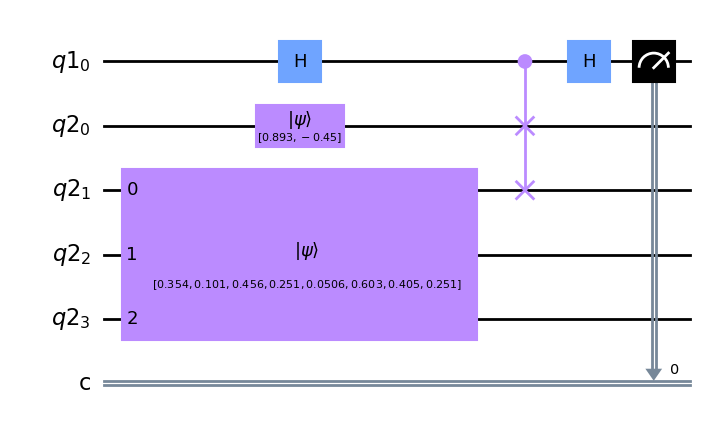

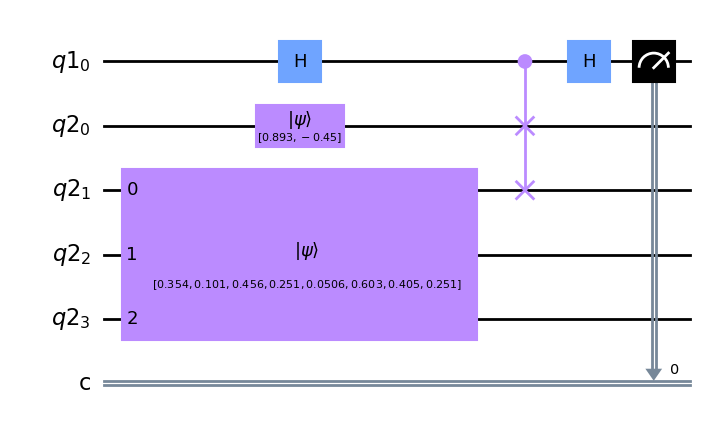

In [29]:
q1 = QuantumRegister(1, name = 'q1')
q2 = QuantumRegister(4, name = 'q2')
c = ClassicalRegister(1, name = 'c')
qc = QuantumCircuit(q1,q2,c)

#States initialization
qc.initialize(phi, q2[0])
qc.initialize(psi, q2[1:4])

# The swap test operator
#qc.x(qreg[1])

#swap_test
qc.h(q1[0])
qc.cswap(q1[0], q2[0], q2[1])
qc.h(q1[0]) 
qc.measure(q1,c)

qc.draw(output="mpl")

In [31]:
shots = 1000
job = execute (qc,Aer.get_backend('qasm_simulator'),shots=shots)
job_result = job.result()
counts = job_result.get_counts(qc)
print(counts)
x = abs(((counts['0']/shots - 0.5)/0.5) * 2 * Z) #.05
Q_Dist = round(m.sqrt(x),4)
print('Quantum Distance: ', round(Q_Dist,3))
print('Euclidean Distance: ',round(Dist,3))

{'0': 627, '1': 373}
Quantum Distance:  22.29
Euclidean Distance:  23.108


# Real quantum computer Belem

In [32]:
IBMQ.load_account()
#IBMQ.provider.backends()
provider = IBMQ.get_provider(hub='ibm-q')#.get_provider()#'ibm-q'
realBackend = provider.get_backend('ibm_nairobi')
print("real device:",realBackend.name())
#job = qk.execute( qc_circuit_1, realBackend )

ibmqfactory.load_account:WARNING:2023-09-18 15:59:34,720: Credentials are already in use. The existing account in the session will be replaced.


real device: ibm_nairobi


## retrieve_job

In [10]:
# job_real = realBackend.retrieve_job('ck4956ilnssf0d4q6n9g')
# counts = job_real.result().get_counts()


In [33]:
qc_list = []
for index in range (0,20):
    qc_list.append(qc)

In [34]:
shots = 4000 #1000 #4000 #10000

job = execute(qc_list,realBackend,shots=shots)#optimization_level=3
# job_result = job.result()
# counts = job.result().get_counts()
# print(counts)
# x = abs(((counts['0']/shots - 0.5)/0.5) * 2 * Z) #.05
# Q_Dist = round(m.sqrt(x),4)
# print('Quantum Distance: ', round(Q_Dist,3))
# print('Euclidean Distance: ',round(Dist,3))

In [ ]:
## ibm_nairobi
#ck4cgp2dijuadev5jhug    ->20 -> 23.108
#ck4cen2lnssf0d4vqdh0    ->19 -> 11.74
#ck4956ilnssf0d4q6n9g    ->1


### Testing
| Provider | Fecha | ID| Status | Qubits |Shots|Quantum distance|Euclidean distance|
| --- | --- | --- | --- | ---- |---- |---- |---- |
Ibmq-Belem|1th February 2023, 10:52 CDMX|63da98d9615264500ad2ad43|○| 5|4000 |4.766 |1 |
Ibmq-Belem|1th February 2023, 11:34 CDMX|63daa296958cc052aa9d21f5|○| 5|1000 |6.55 |1 |
Ibmq-Belem|6th February 2023, 09:04 CDMX|63e1bfb86fb5c06f02d7da61|○| 5|4000 |7.409 |1|
Ibmq-Belem|6th February 2023, 09:44 CDMX|63e1c937ce494c6d1eb8240d|○| 5|10000|8.846 |1 |
Ibmq-Belem|6th February 2023, 10:03 CDMX|63e1cda3ce494c8a7eb82417|○| 5|4000|4.897 |1 |
IonQ|20th April 2023, 11:09 CDMX|arn:aws:braket:us-east-1:592242689881:quantum-task/9659180b-5e28-431f-af28-ea032a7fbef6|○| 11|1000|7.452 |1 |
IonQ|20th April 2023, 10:57 CDMX|arn:aws:braket:us-east-1:592242689881:quantum-task/0b5b82f1-21ff-4625-bb43-e7a0606e2b19|○| 11|100|7.105 |1 |
OQC|26th June 2023, 10:26 CDMX|arn:aws:braket:eu-west-2:592242689881:quantum-task/75277cc5-bab4-49e8-aea4-649f21a23d33|○| 8|100|15.072 |1 |
OQC|26th June 2023, 10:28 CDMX|arn:aws:braket:eu-west-2:592242689881:quantum-task/75277cc5-bab4-49e8-aea4-649f21a23d33|○| 8|1000|15.887 |1 |
Aria-1|26th June 2023, 10:38 CDMX|arn:aws:braket:eu-west-2:592242689881:quantum-task/75277cc5-bab4-49e8-aea4-649f21a23d33|○| 25|100|15.072 |1 |
Aria-1|26th June 2023, 10:38 CDMX|arn:aws:braket:eu-west-2:592242689881:quantum-task/75277cc5-bab4-49e8-aea4-649f21a23d33|○| 25|1000|10.173 |1 |
ibm-Nairobi|18th September 2023, 12:00 CDMX|ck4956ilnssf0d4q6n9g|○| 7|4000|14.344 |11.747|